# Imports

In [2]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

## Datasets

In [13]:
col_names = ['width', 'height', 'value']
r800 = pd.read_csv('data/cutting/r800.csv', header=None, names=col_names)
r850 = pd.read_csv('data/cutting/r850.csv', header=None, names=col_names)
r1000 = pd.read_csv('data/cutting/r1000.csv', header=None, names=col_names)
r1100 = pd.read_csv('data/cutting/r1100.csv', header=None, names=col_names)
r1200 = pd.read_csv('data/cutting/r1200.csv', header=None, names=col_names)

r800['id'] = range(1, len(r800) + 1)
r850['id'] = range(1, len(r850) + 1)
r1000['id'] = range(1, len(r1000) + 1)
r1100['id'] = range(1, len(r1100) + 1)
r1200['id'] = range(1, len(r1200) + 1)

In [14]:
r800

,width,height,value,id
0,250,120,100,1
1,320,160,500,2
2,250,160,600,3
3,150,120,40,4
4,400,30,400,5


In [39]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle
import copy

class Rectangle:
    def __init__(self, width, height, value, rect_id):
        self.width = width
        self.height = height
        self.value = value
        self.id = rect_id
    
    def __repr__(self):
        return f"Rect(id={self.id}, w={self.width}, h={self.height}, v={self.value})"

class Gene:
    def __init__(self, x, y, rect_id):
        self.x = x
        self.y = y
        self.rect_id = rect_id
    
    def __repr__(self):
        return f"Gene(x={self.x:.2f}, y={self.y:.2f}, id={self.rect_id})"

class Individual:
    def __init__(self, genes=None):
        self.genes = genes if genes else []
        self.fitness = 0
        self.valid = False
    
    def copy(self):
        new_genes = [Gene(g.x, g.y, g.rect_id) for g in self.genes]
        new_individual = Individual(new_genes)
        new_individual.fitness = self.fitness
        new_individual.valid = self.valid
        return new_individual

class CircularCuttingGA:
    def __init__(self, rectangles, radius, population_size=100, max_rectangles=50):
        self.rectangles = rectangles
        self.radius = radius
        self.population_size = population_size
        self.max_rectangles = max_rectangles
        self.population = []
        
    def create_random_individual(self):
        """Create a random individual with symmetric placement"""
        individual = Individual()
        num_rects = random.randint(1, min(self.max_rectangles, 20))
        
        for _ in range(num_rects):
            rect_id = random.choice(range(len(self.rectangles)))
            rect = self.rectangles[rect_id]
            max_x = self.radius - rect.width/2
            max_y = self.radius - rect.height/2
            
            if max_x > 0 and max_y > 0:
                x = random.uniform(-max_x, max_x)
                y = random.uniform(0, max_y)
                if self.rectangle_fits_in_circle(x, y, rect):
                    individual.genes.append(Gene(x, y, rect_id))
        
        return individual
    
    def rectangle_fits_in_circle(self, x, y, rect):
        """Check if rectangle centered at (x,y) fits in circle"""
        corners = [
            (x - rect.width/2, y - rect.height/2),
            (x + rect.width/2, y - rect.height/2),
            (x - rect.width/2, y + rect.height/2),
            (x + rect.width/2, y + rect.height/2)
        ]
        
        for cx, cy in corners:
            if cx*cx + cy*cy > self.radius*self.radius:
                return False
        return True
    
    def get_all_rectangles_from_individual(self, individual):
        """Get all rectangles including symmetric ones"""
        all_rects = []
        
        for gene in individual.genes:
            rect = self.rectangles[gene.rect_id]
            all_rects.append((gene.x, gene.y, rect))
            if abs(gene.y) > 1e-6:
                all_rects.append((gene.x, -gene.y, rect))
        
        return all_rects
    
    def rectangles_overlap(self, x1, y1, rect1, x2, y2, rect2):
        """Check if two rectangles overlap"""
        left1 = x1 - rect1.width/2
        right1 = x1 + rect1.width/2
        bottom1 = y1 - rect1.height/2
        top1 = y1 + rect1.height/2
        
        left2 = x2 - rect2.width/2
        right2 = x2 + rect2.width/2
        bottom2 = y2 - rect2.height/2
        top2 = y2 + rect2.height/2
        
        return not (right1 <= left2 or right2 <= left1 or top1 <= bottom2 or top2 <= bottom1)
    
    def evaluate_fitness(self, individual):
        """Evaluate fitness of an individual"""
        all_rects = self.get_all_rectangles_from_individual(individual)
        
        for x, y, rect in all_rects:
            if not self.rectangle_fits_in_circle(x, y, rect):
                individual.fitness = 0
                individual.valid = False
                return 0
        
        for i in range(len(all_rects)):
            for j in range(i + 1, len(all_rects)):
                x1, y1, rect1 = all_rects[i]
                x2, y2, rect2 = all_rects[j]
                if self.rectangles_overlap(x1, y1, rect1, x2, y2, rect2):
                    individual.fitness = 0
                    individual.valid = False
                    return 0
        
        total_value = 0
        for gene in individual.genes:
            rect = self.rectangles[gene.rect_id]
            if abs(gene.y) > 1e-6:
                total_value += 2 * rect.value
            else:
                total_value += rect.value
        
        individual.fitness = total_value
        individual.valid = True
        return total_value
    
    def initialize_population(self):
        """Initialize random population"""
        self.population = []
        for _ in range(self.population_size):
            individual = self.create_random_individual()
            self.evaluate_fitness(individual)
            self.population.append(individual)
    
    def tournament_selection(self, tournament_size=3):
        """Tournament selection"""
        tournament = random.sample(self.population, tournament_size)
        return max(tournament, key=lambda x: x.fitness)
    
    def crossover(self, parent1, parent2):
        """Single-point crossover"""
        if len(parent1.genes) == 0 or len(parent2.genes) == 0:
            return parent1.copy(), parent2.copy()
        
        child1 = Individual()
        child2 = Individual()
        
        all_genes1 = parent1.genes + parent2.genes
        all_genes2 = parent2.genes + parent1.genes
        
        max_genes = min(self.max_rectangles, len(all_genes1))
        num_genes1 = random.randint(1, max_genes)
        num_genes2 = random.randint(1, max_genes)
        
        child1.genes = random.sample(all_genes1, min(num_genes1, len(all_genes1)))
        child2.genes = random.sample(all_genes2, min(num_genes2, len(all_genes2)))
        
        return child1, child2
    
    def mutate(self, individual, mutation_rate=0.1):
        """Mutation operator"""
        mutated = individual.copy()
        
        for gene in mutated.genes:
            if random.random() < mutation_rate:
                rect = self.rectangles[gene.rect_id]
                max_x = self.radius - rect.width/2
                max_y = self.radius - rect.height/2
                
                if max_x > 0 and max_y > 0:
                    gene.x = random.uniform(-max_x, max_x)
                    gene.y = random.uniform(0, max_y)
        
        if random.random() < mutation_rate and len(mutated.genes) < self.max_rectangles:
            rect_id = random.choice(range(len(self.rectangles)))
            rect = self.rectangles[rect_id]
            max_x = self.radius - rect.width/2
            max_y = self.radius - rect.height/2
            
            if max_x > 0 and max_y > 0:
                x = random.uniform(-max_x, max_x)
                y = random.uniform(0, max_y)
                if self.rectangle_fits_in_circle(x, y, rect):
                    mutated.genes.append(Gene(x, y, rect_id))
        
        if random.random() < mutation_rate and len(mutated.genes) > 1:
            mutated.genes.pop(random.randint(0, len(mutated.genes) - 1))
        
        return mutated
    
    def evolve(self, generations=100):
        """Main evolution loop"""
        self.initialize_population()
        best_fitness_history = []
        
        for generation in range(generations):
            for individual in self.population:
                self.evaluate_fitness(individual)
            
            self.population.sort(key=lambda x: x.fitness, reverse=True)
            best_fitness = self.population[0].fitness
            best_fitness_history.append(best_fitness)
            new_population = []
            elite_size = self.population_size // 10
            new_population.extend([ind.copy() for ind in self.population[:elite_size]])
            while len(new_population) < self.population_size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()
                
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                
                new_population.extend([child1, child2])
            
            self.population = new_population[:self.population_size]
        
        return best_fitness_history
    
    def visualize_solution(self, individual):
        """Visualize the solution"""
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        circle = Circle((0, 0), self.radius, fill=False, color='black', linewidth=2)
        ax.add_patch(circle)
        
        all_rects = self.get_all_rectangles_from_individual(individual)
        colors = plt.cm.Set3(np.linspace(0, 1, len(self.rectangles)))
        
        total_value = 0
        for x, y, rect in all_rects:
            color = colors[rect.id % len(colors)]
            rectangle = patches.Rectangle(
                (x - rect.width/2, y - rect.height/2),
                rect.width, rect.height,
                linewidth=1, edgecolor='black', facecolor=color, alpha=0.7
            )
            ax.add_patch(rectangle)
            
            ax.text(x, y, f'ID:{rect.id}\nV:{rect.value}', 
                   ha='center', va='center', fontsize=8, fontweight='bold')
            
            total_value += rect.value
        
        ax.set_xlim(-self.radius * 1.1, self.radius * 1.1)
        ax.set_ylim(-self.radius * 1.1, self.radius * 1.1)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_title(f'Circular Cutting Stock Solution\nTotal Value: {total_value}\nValid: {individual.valid}')
        
        plt.tight_layout()
        plt.show()



Best solution:
Fitness: 16000
Valid: True
Number of genes: 17


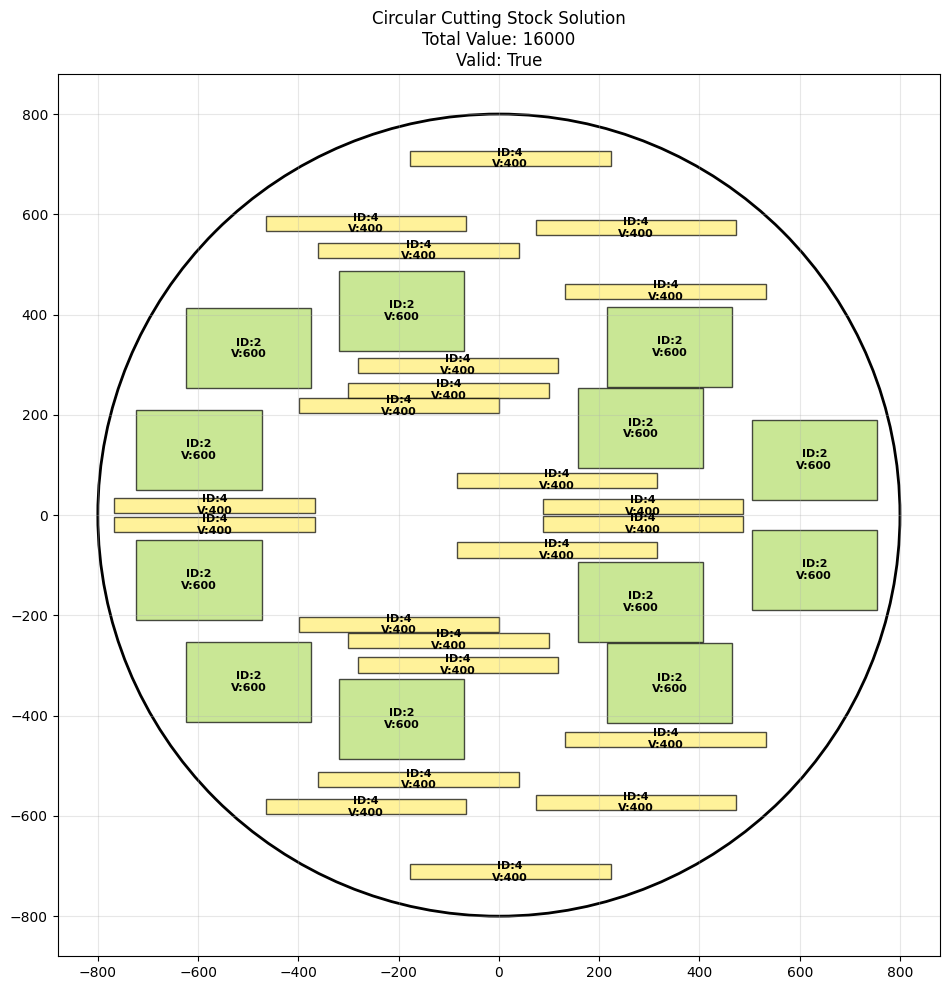

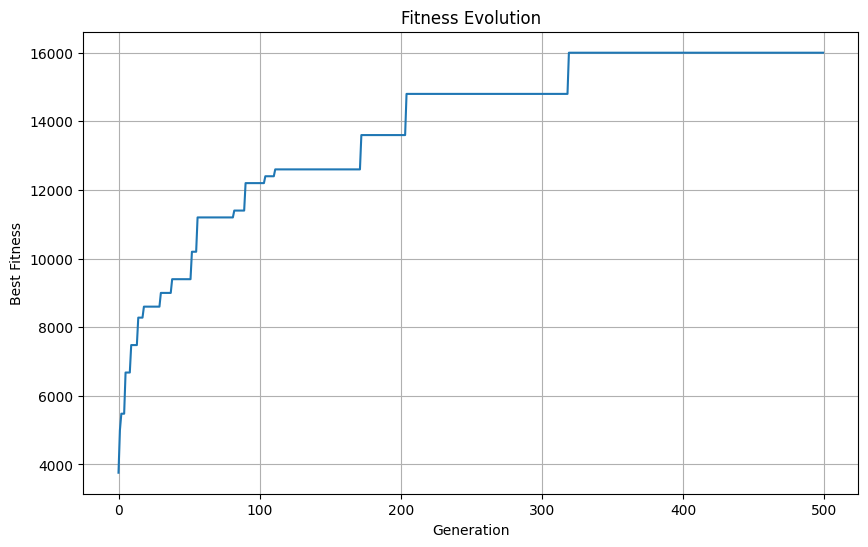

In [43]:
chosen_ds = r800
col_names = ['width', 'height', 'value']
chosen_ds['id'] = range(len(chosen_ds))

rectangles = []
for _, row in chosen_ds.iterrows():
    rectangles.append(Rectangle(row['width'], row['height'], row['value'], row['id']))

radius = 800
ga = CircularCuttingGA(rectangles, radius, population_size=300, max_rectangles=500)

fitness_history = ga.evolve(generations=500)

best_individual = max(ga.population, key=lambda x: x.fitness)
print(f"\nBest solution:")
print(f"Fitness: {best_individual.fitness}")
print(f"Valid: {best_individual.valid}")
print(f"Number of genes: {len(best_individual.genes)}")

ga.visualize_solution(best_individual)

plt.figure(figsize=(10, 6))
plt.plot(fitness_history)
plt.title('Fitness Evolution')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.grid(True)
plt.show()



Best solution:
Fitness: 291100
Valid: True
Number of genes: 16


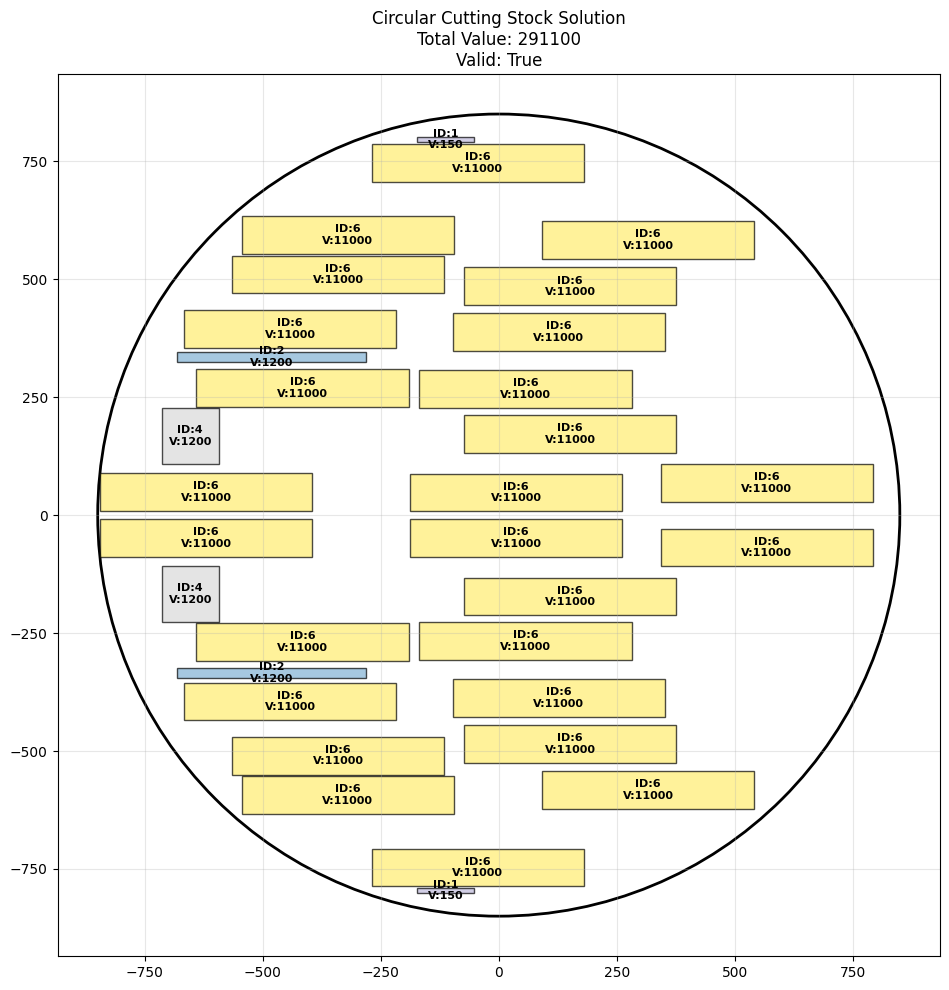

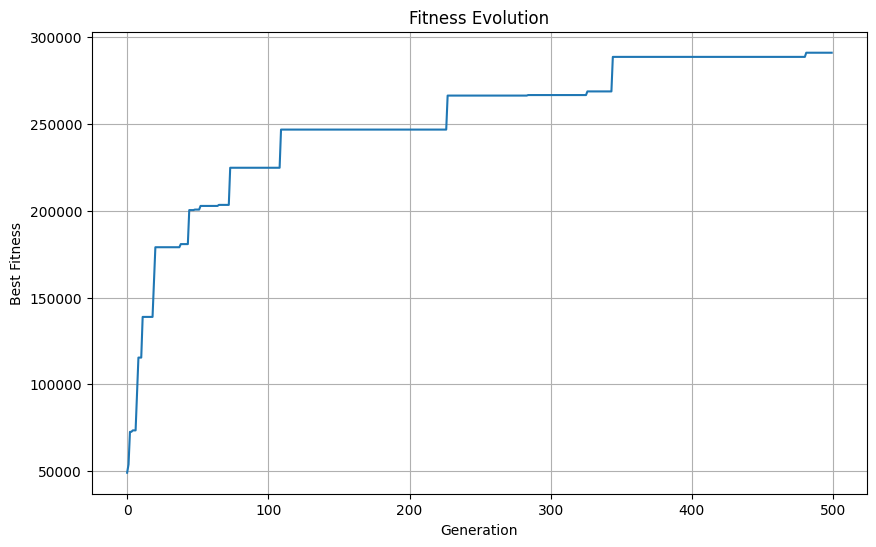

In [51]:
chosen_ds = r850
col_names = ['width', 'height', 'value']
chosen_ds['id'] = range(len(chosen_ds))

rectangles = []
for _, row in chosen_ds.iterrows():
    rectangles.append(Rectangle(row['width'], row['height'], row['value'], row['id']))

radius = 850
ga = CircularCuttingGA(rectangles, radius, population_size=300, max_rectangles=500)

fitness_history = ga.evolve(generations=500)

best_individual = max(ga.population, key=lambda x: x.fitness)
print(f"\nBest solution:")
print(f"Fitness: {best_individual.fitness}")
print(f"Valid: {best_individual.valid}")
print(f"Number of genes: {len(best_individual.genes)}")

ga.visualize_solution(best_individual)

plt.figure(figsize=(10, 6))
plt.plot(fitness_history)
plt.title('Fitness Evolution')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.grid(True)
plt.show()



Best solution:
Fitness: 13000
Valid: True
Number of genes: 16


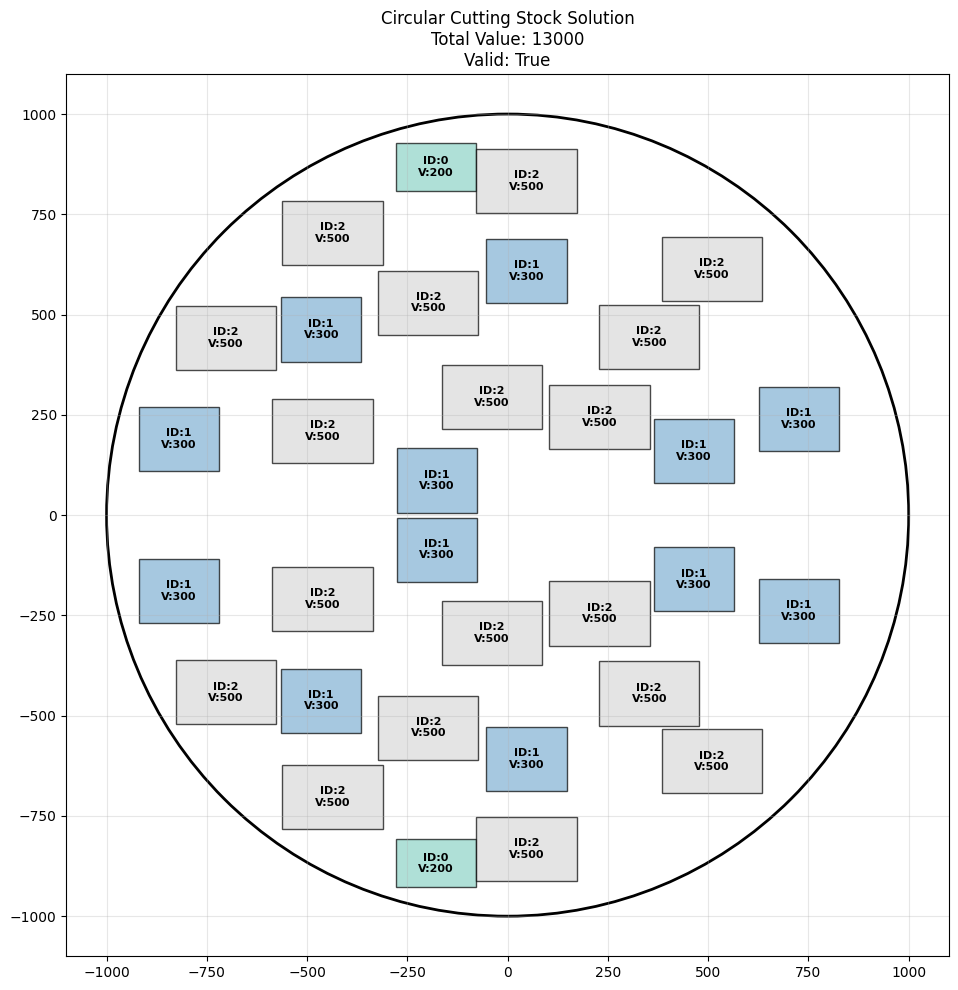

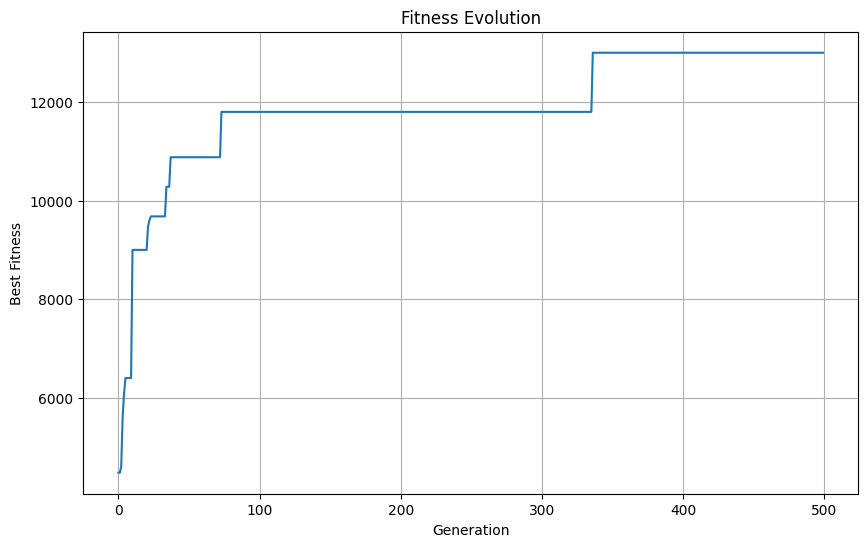

In [50]:
chosen_ds = r1000
col_names = ['width', 'height', 'value']
chosen_ds['id'] = range(len(chosen_ds))

rectangles = []
for _, row in chosen_ds.iterrows():
    rectangles.append(Rectangle(row['width'], row['height'], row['value'], row['id']))

radius = 1000
ga = CircularCuttingGA(rectangles, radius, population_size=300, max_rectangles=500)

fitness_history = ga.evolve(generations=500)

best_individual = max(ga.population, key=lambda x: x.fitness)
print(f"\nBest solution:")
print(f"Fitness: {best_individual.fitness}")
print(f"Valid: {best_individual.valid}")
print(f"Number of genes: {len(best_individual.genes)}")

ga.visualize_solution(best_individual)

plt.figure(figsize=(10, 6))
plt.plot(fitness_history)
plt.title('Fitness Evolution')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.grid(True)
plt.show()



Best solution:
Fitness: 18280
Valid: True
Number of genes: 17


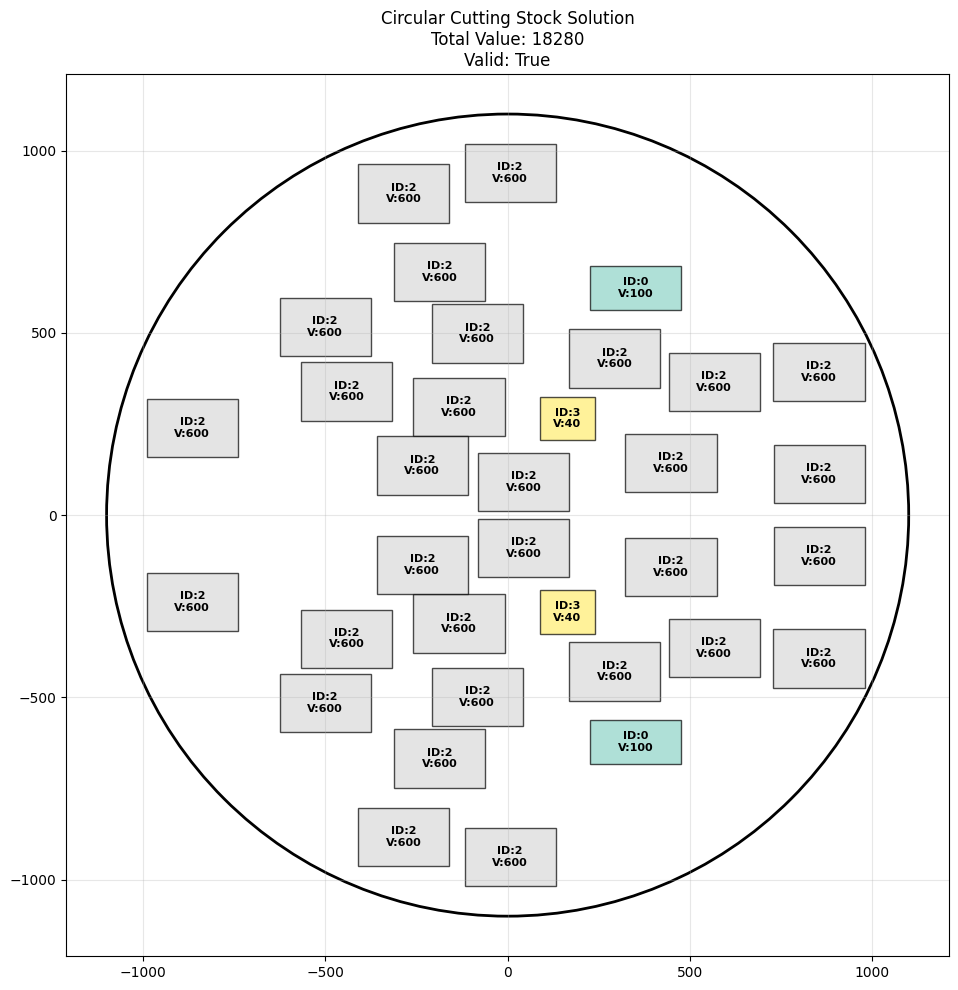

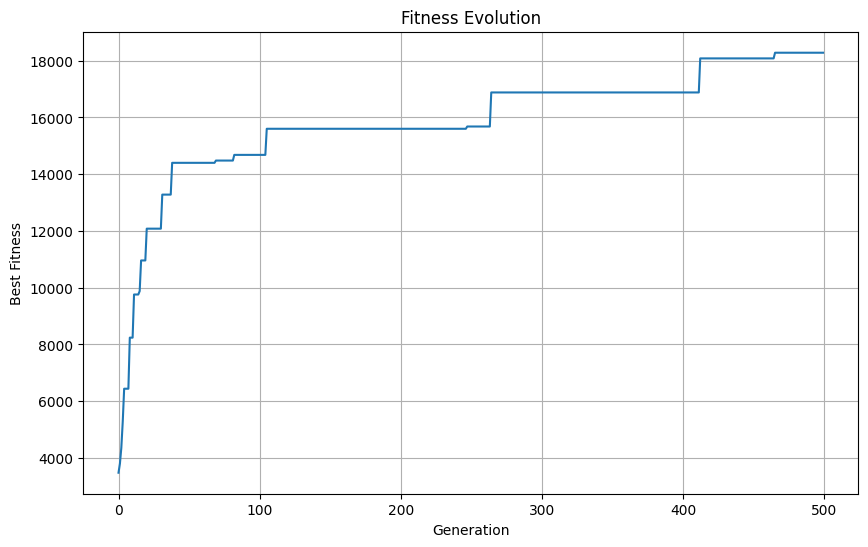

In [49]:
chosen_ds = r1100
col_names = ['width', 'height', 'value']
chosen_ds['id'] = range(len(chosen_ds))

rectangles = []
for _, row in chosen_ds.iterrows():
    rectangles.append(Rectangle(row['width'], row['height'], row['value'], row['id']))

radius = 1100
ga = CircularCuttingGA(rectangles, radius, population_size=300, max_rectangles=500)

fitness_history = ga.evolve(generations=500)

best_individual = max(ga.population, key=lambda x: x.fitness)
print(f"\nBest solution:")
print(f"Fitness: {best_individual.fitness}")
print(f"Valid: {best_individual.valid}")
print(f"Number of genes: {len(best_individual.genes)}")

ga.visualize_solution(best_individual)

plt.figure(figsize=(10, 6))
plt.plot(fitness_history)
plt.title('Fitness Evolution')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.grid(True)
plt.show()



Best solution:
Fitness: 16400
Valid: True
Number of genes: 17


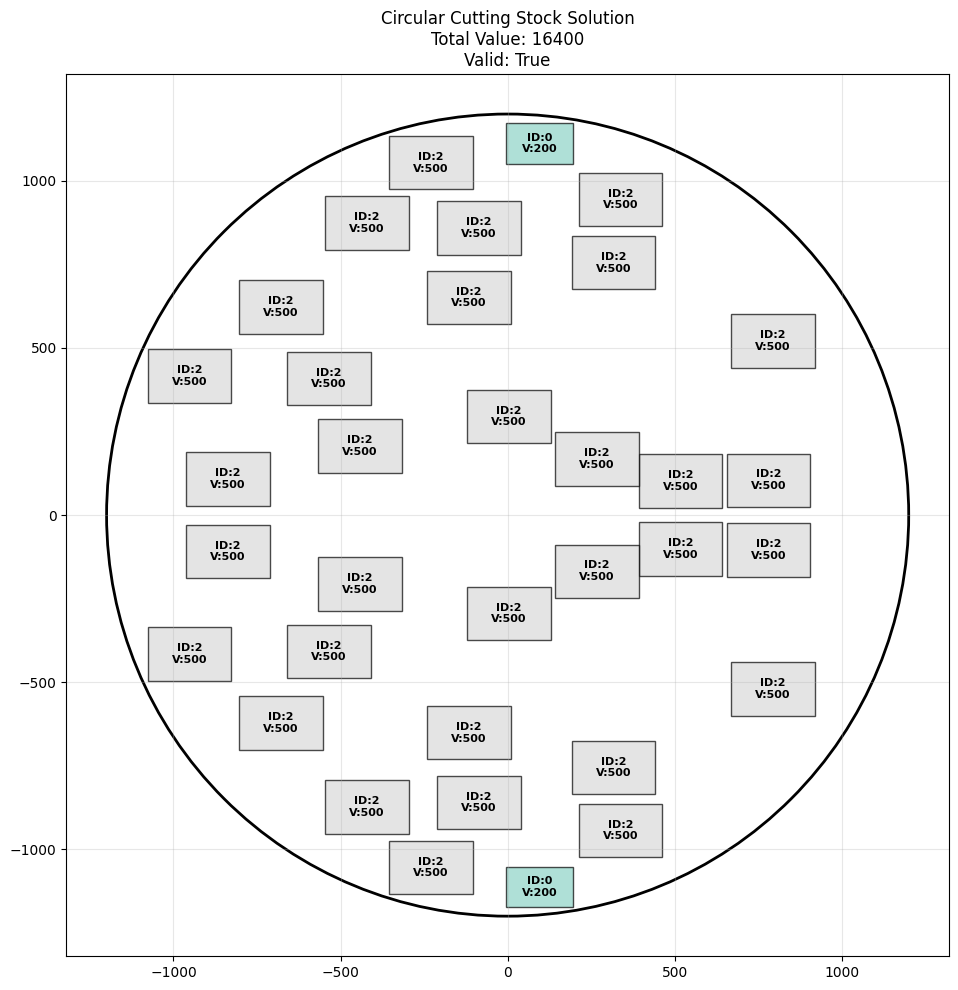

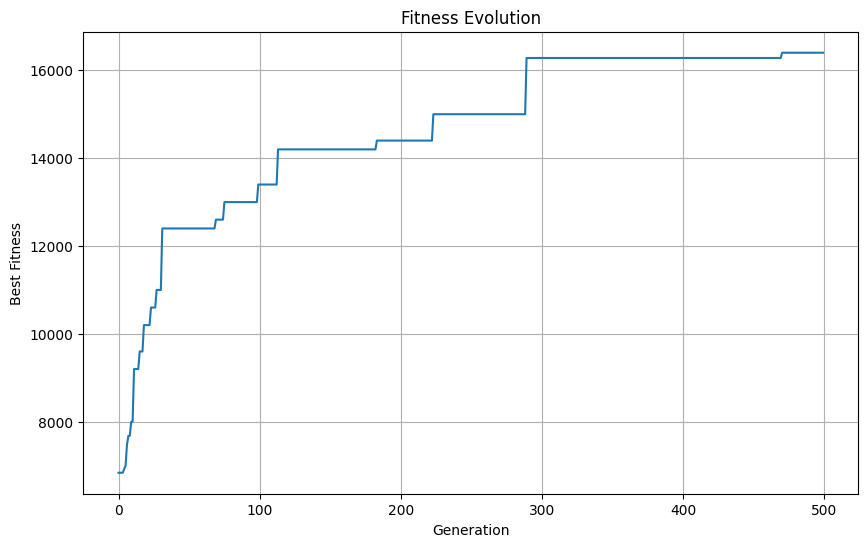

In [48]:
chosen_ds = r1200
col_names = ['width', 'height', 'value']
chosen_ds['id'] = range(len(chosen_ds))

rectangles = []
for _, row in chosen_ds.iterrows():
    rectangles.append(Rectangle(row['width'], row['height'], row['value'], row['id']))

radius = 1200
ga = CircularCuttingGA(rectangles, radius, population_size=300, max_rectangles=500)

fitness_history = ga.evolve(generations=500)

best_individual = max(ga.population, key=lambda x: x.fitness)
print(f"\nBest solution:")
print(f"Fitness: {best_individual.fitness}")
print(f"Valid: {best_individual.valid}")
print(f"Number of genes: {len(best_individual.genes)}")

ga.visualize_solution(best_individual)

plt.figure(figsize=(10, 6))
plt.plot(fitness_history)
plt.title('Fitness Evolution')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.grid(True)
plt.show()
